In [1]:
# Import some of the required libraries
from operator import sub
from numpy.core.numeric import roll
import pandas as pd
import numpy as np
from arch import arch_model
from sklearn.covariance import LedoitWolf
import matplotlib.pyplot as plt
from glob import glob
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import norm
from scipy import stats
from scipy.special import erf
import matplotlib.pyplot as plt
from sklearn import cluster, datasets, mixture
from scipy.stats import multivariate_normal,kstest,norm,t
from scipy.interpolate import interp1d
from scipy.stats import kurtosis, skew
from scipy.special import erf
from joblib import Parallel, delayed
from scipy.optimize import minimize
from statsmodels.distributions.empirical_distribution import ECDF
from pandas.tseries.offsets import Day, BDay
from datetime import date
import matplotlib.ticker as mtick
import os
import h5py
from joblib import wrap_non_picklable_objects
from hmmlearn import hmm
# Load our own helper and plottingfunctions
#from plottingfunctions import *
#from helperfunctions import *
# Set number of cores if we do something parallel
Ncores=6
# Set stylesheet for nice plotting
plt.style.use('../QRM1/OOP/stylesheet')

In [12]:
def load_timeseries_new():
    try:
        joined = pd.read_pickle('All_timeseries.pickle')
    except:
        df = pd.read_pickle('./timeseries/indices.pickle')
        # Load US treasuries
        UST5 = pd.read_excel('./timeseries/treasury_5y.xls',header=None)
        UST5.columns = ['Date','Treasury5y']
        UST5.Date = pd.to_datetime(UST5.Date)
        UST5 = UST5.set_index('Date')
        UST5 = UST5.diff()
        # Load AEX
        aex = pd.read_csv('./timeseries/AEX.csv')
        aex['Date'] = pd.to_datetime(aex['Date'])
        aex=  aex.set_index('Date')
        aex = aex[['Close']]
        aex.columns = ['AEX']
        aex = np.log(aex/aex.shift(1)).dropna()
        # Load EUR/USD
        EUR_USD = pd.read_excel('./timeseries/EUR_USD.xls')
        EUR_USD.observation_date = pd.to_datetime(EUR_USD.observation_date)
        EUR_USD = EUR_USD.set_index('observation_date')
        EUR_USD = np.log(EUR_USD/EUR_USD.shift(1))
        # Load EUR/Turkish Lira
        EUR_TRY = pd.read_excel('./timeseries/EUR_TRY.xlsx')
        EUR_TRY.Date = pd.to_datetime(EUR_TRY.Date)
        EUR_TRY = EUR_TRY.set_index('Date')['TRY']
        EUR_TRY = np.log(EUR_TRY/EUR_TRY.shift(1))
        EUR_TRY = EUR_TRY.dropna()
        # Load BIST (turkish stock index)
        bist = pd.read_csv('./timeseries/bist_all_shares.csv')
        bist['Date'] = pd.to_datetime(bist['Date'])
        bist=  bist.set_index('Date')
        bist = bist[['Close']]
        bist.columns = ['Bist']
        bist = np.log(bist/bist.shift(1))
        bist['Bist'].loc['2020-07-27'] = bist['Bist'].mean()
        # Join all
        joined = df.join(EUR_USD).join(EUR_TRY).join(bist).join(UST5).join(aex)
        joined = joined.dropna()
        joined = joined.loc['2011':]
        # Convert to EUR
        joined['Bist EUR'] = joined['Bist'] + joined['TRY']
        joined['Commodities EUR'] = joined['Commodities'] + joined['DEXUSEU']
        joined['US CMBL EUR'] = joined['US CMBL'] + joined['DEXUSEU']
        joined['Nasdaq EUR'] = joined['Nasdaq'] + joined['DEXUSEU']
        joined['Emerging equity EUR'] = joined['Emerging equity'] + joined['DEXUSEU']
        joined['Private Debt EUR'] = joined['Private Debt'] + joined['DEXUSEU']
        joined.to_pickle('All_timeseries.pickle')
    return joined
returns = load_timeseries_new()

In [16]:
returns = returns - returns.mean()

In [17]:
stocks = ['Europe Equity',
          'France All Maturities',
          'AEX',
          'Bist',
          'Commodities',
          'US CMBL',
          'Nasdaq',
          'Emerging equity',
          'Private Debt']
# Make summary table
summary_df = pd.DataFrame({'Annualized mean return':returns.mean()*252*100,
                           'Annualized volatility': returns.std()*np.sqrt(252)*100,
                           'Kurtosis':kurtosis(returns),
                           'Skewness':skew(returns)})
#print(summary_df.loc[stocks].round(2).sort_index().to_latex(bold_rows=True))

# Plot
#plot_timeseries(returns[stocks])
# Do some testing for normality assumptions

# Make QQ plot
#qq_plot(returns[stocks], dist='normal')
#qq_plot(returns[stocks], dist='t',nu=4.5)
# Make CDF plots
#CDFs(returns[stocks[2:]])
# Make GARCH and EWMA plot
#EWMA_GARCH(returns[stocks[2:]])

<h3>PCA on daily returns</h3>

In [23]:
from numpy.linalg import eig
corrmat = returns[stocks].corr()
w,v = eig(corrmat)
sort_ = np.argsort(w)[::-1]
w=w[sort_]
v=v[sort_]

cum_expl_corr = np.hstack(([0],np.cumsum(w)))
cum_expl_corr = cum_expl_corr/np.sum(w)

In [24]:
from numpy.linalg import eig
corrmat = returns[stocks].cov()
w,v = eig(corrmat)
sort_ = np.argsort(w)[::-1]
w=w[sort_]
v=v[sort_]

cum_expl_cov = np.hstack(([0],np.cumsum(w)))
cum_expl_cov = cum_expl_cov/np.sum(w)

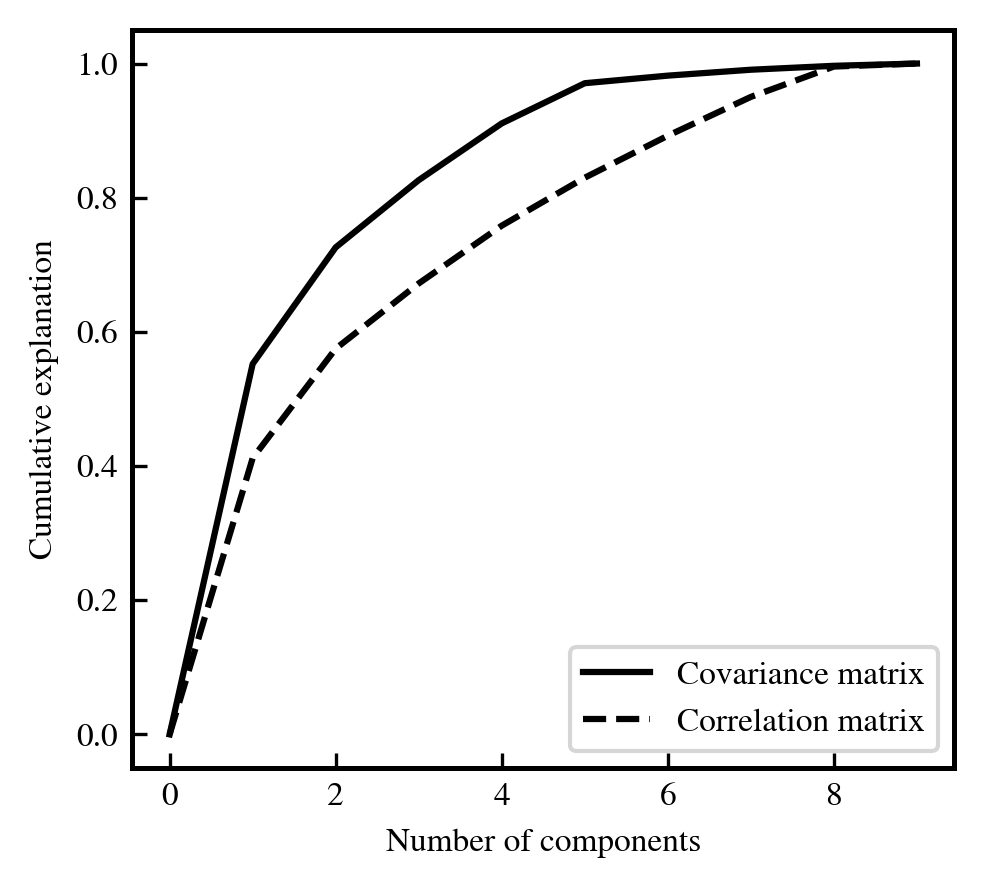

In [30]:
plt.plot(np.arange(0,len(cum_expl)),cum_expl_cov,label='Covariance matrix',color='black',lw=1.5)
plt.plot(np.arange(0,len(cum_expl)),cum_expl_corr,label='Correlation matrix',color='black', ls='--',lw=1.5)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explanation')
plt.legend(frameon=1)
plt.tight_layout()
plt.savefig('cumulative_explained_PCA.pdf')

In [31]:
factor_loadings = pd.DataFrame(v, index=stocks)

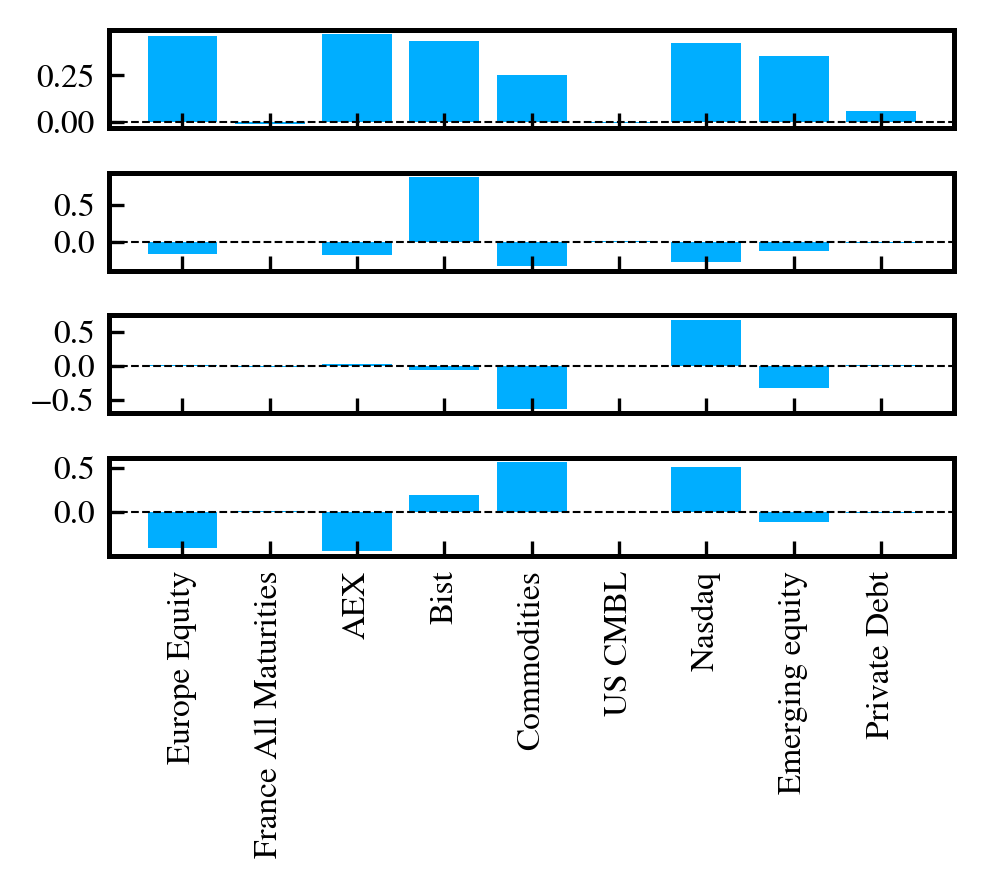

In [41]:
fix,axes = plt.subplots(nrows=4,sharex=True)

axes[0].bar(stocks,factor_loadings.iloc[:,0])
axes[0].axhline(0,ls='--',color='black',lw=0.5)

axes[1].bar(stocks,factor_loadings.iloc[:,1])
axes[1].axhline(0,ls='--',color='black',lw=0.5)

axes[2].bar(stocks,factor_loadings.iloc[:,2])
axes[2].axhline(0,ls='--',color='black',lw=0.5)

axes[3].bar(stocks,factor_loadings.iloc[:,3])
axes[3].axhline(0,ls='--',color='black',lw=0.5)

plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('factor_loadings.pdf',bbox_inches='tight')
plt.show()

In [76]:
# Numerically obtain inverse CDF of GMM
def inverse_GMM_arbitraryCDF(CDF):

    def diff(x,function,a):

        y = function(x)

        return (y-a)**2

    # Define normal CDF of GMM

    # Now define a grid over which to equate the inverse

    # For that we need to get the min and max; we know thats 0 and 1

    xvalues = np.linspace(1e-10,1-1e-10,2000)

    # For each of these x values, determine the inverse using minimization

   

    inverses = np.zeros(len(xvalues))

    for i in range(len(inverses)):

        res = minimize(diff, x0=0, args=(CDF,xvalues[i]), method='Nelder-Mead', tol=1e-11)

        inverses[i] = res.x

    # Do interpolation of this

    f = interp1d(xvalues,inverses,fill_value='extrapolate')

    return f, xvalues, inverses


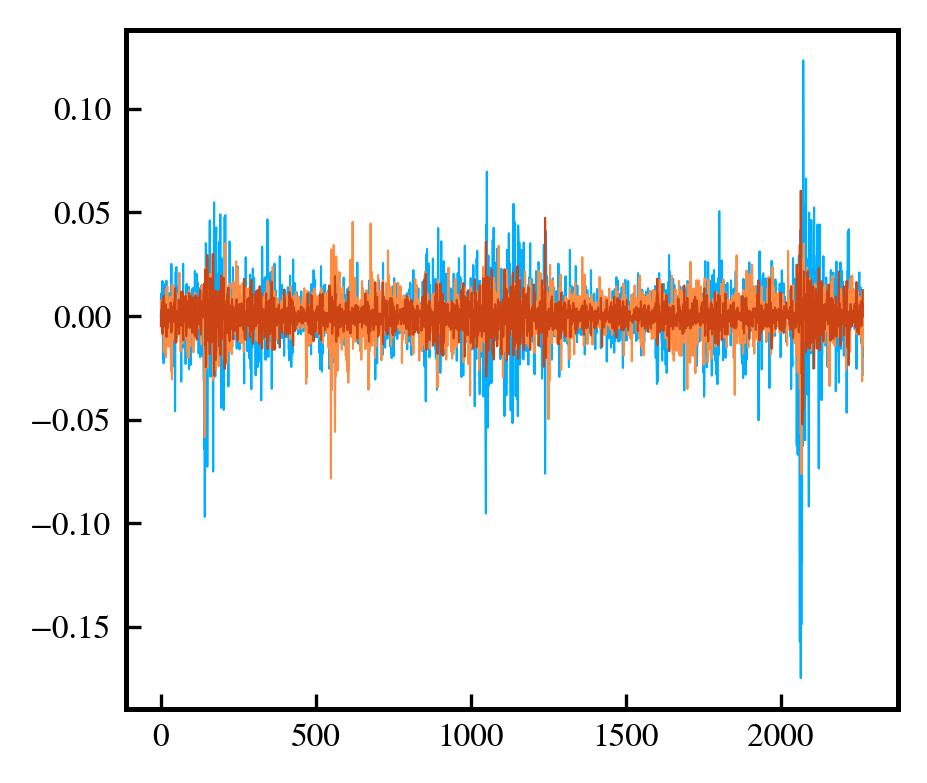

In [13]:
plt.plot(np.dot(factor_loadings.iloc[:,0],returns[stocks].T),lw=0.5,)
plt.plot(np.dot(factor_loadings.iloc[:,1],returns[stocks].T),lw=0.5)
plt.plot(np.dot(factor_loadings.iloc[:,2],returns[stocks].T),lw=0.5)

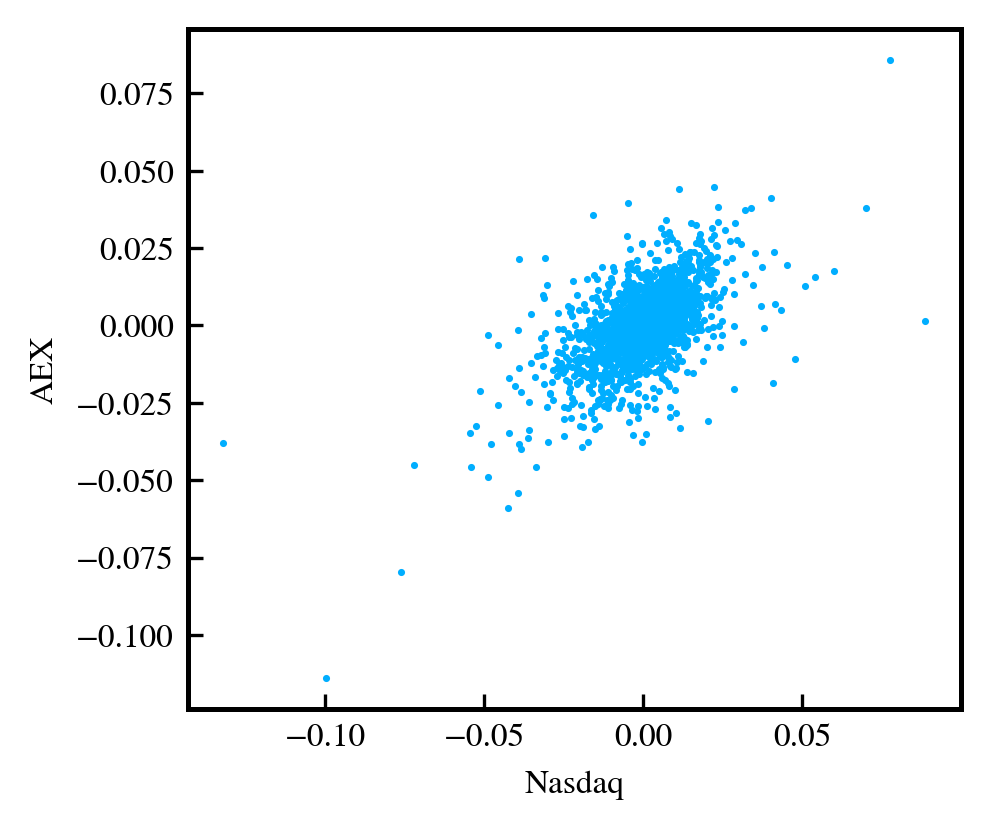

In [14]:
returns[['Nasdaq', 'AEX']].plot.scatter(x='Nasdaq', y='AEX',s=0.5)

In [15]:
ecdf_nasdaq = ECDF(returns['Nasdaq'])
ecdf_aex    = ECDF(returns['AEX'])

In [16]:
nasdaq_uniform = ecdf_nasdaq(returns['Nasdaq'])
aex_uniform = ecdf_aex(returns['AEX'])

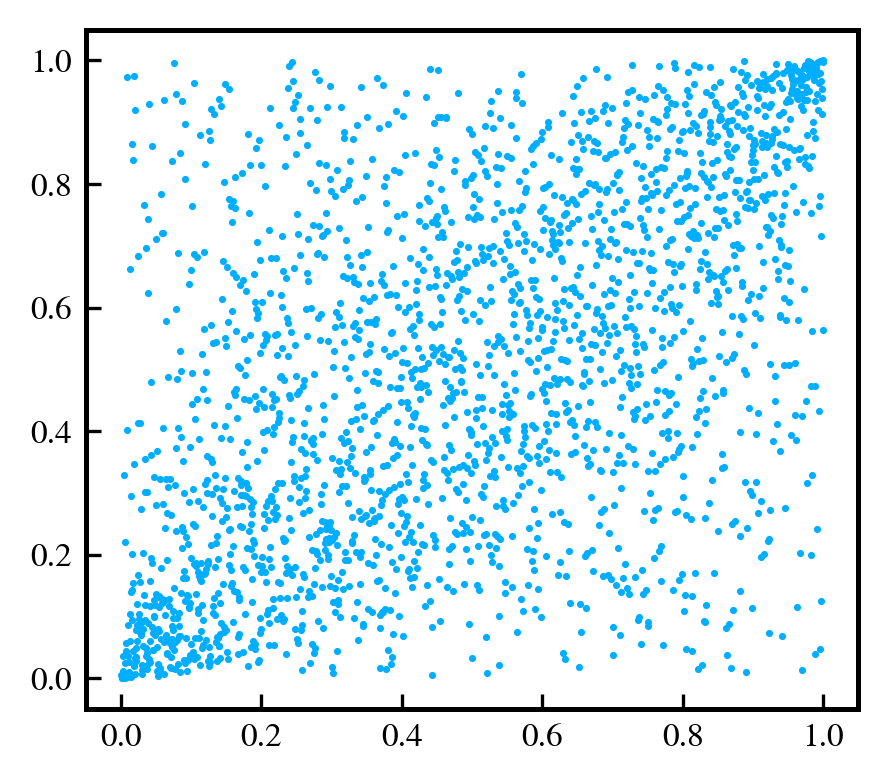

In [17]:
plt.scatter(nasdaq_uniform, aex_uniform,s=0.5)

In [18]:
import copula
from copulae import GaussianCopula

In [63]:
from copulae import GaussianCopula

g_cop = GaussianCopula(dim=9)  # initializing the copula
g_cop.fit(returns[stocks])  # fit the copula to the data

/home/luuk/anaconda3/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


In [64]:
from copulae import 

In [ ]:
g_cop.log_lik(returns[stocks])

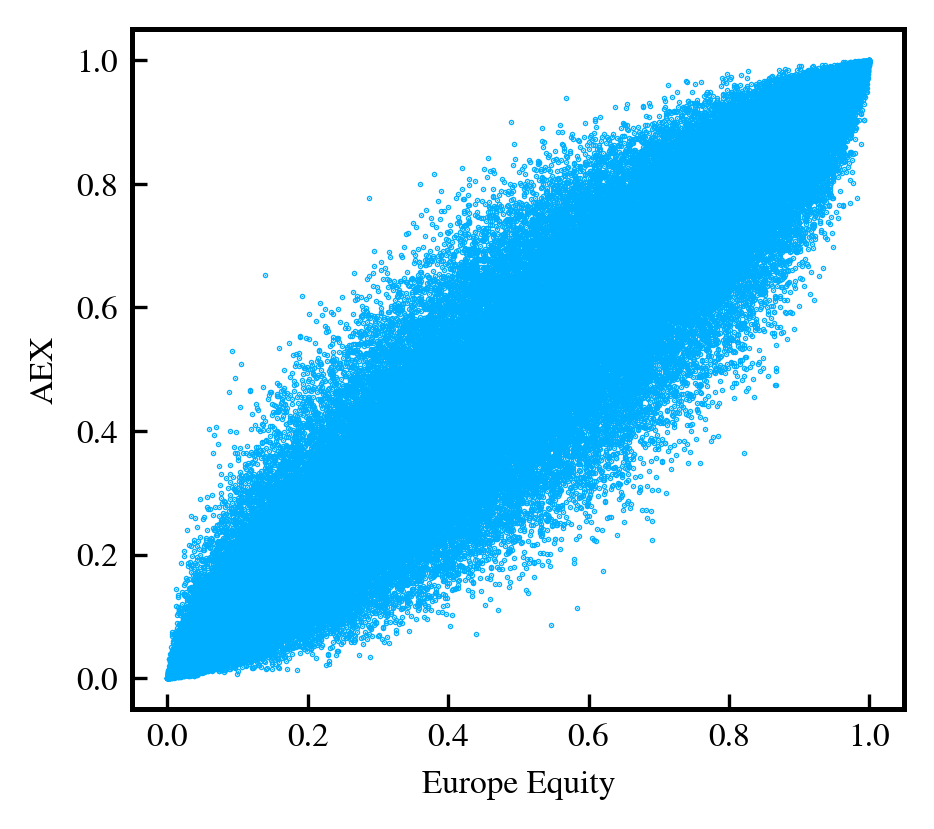

In [75]:
g_cop.random(100000).plot.scatter(x='Europe Equity', y='AEX',s=0.1)

In [33]:
from copulae import StudentCopula

degrees_of_freedom = 3.5  # some random number, unnecessary to specify df but done for demonstration purposes
t_cop = StudentCopula(dim=9, df=degrees_of_freedom)
t_cop.fit(returns[stocks])

/home/luuk/anaconda3/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


In [34]:
t_cop.log_lik(returns[stocks])

5052.811641939703

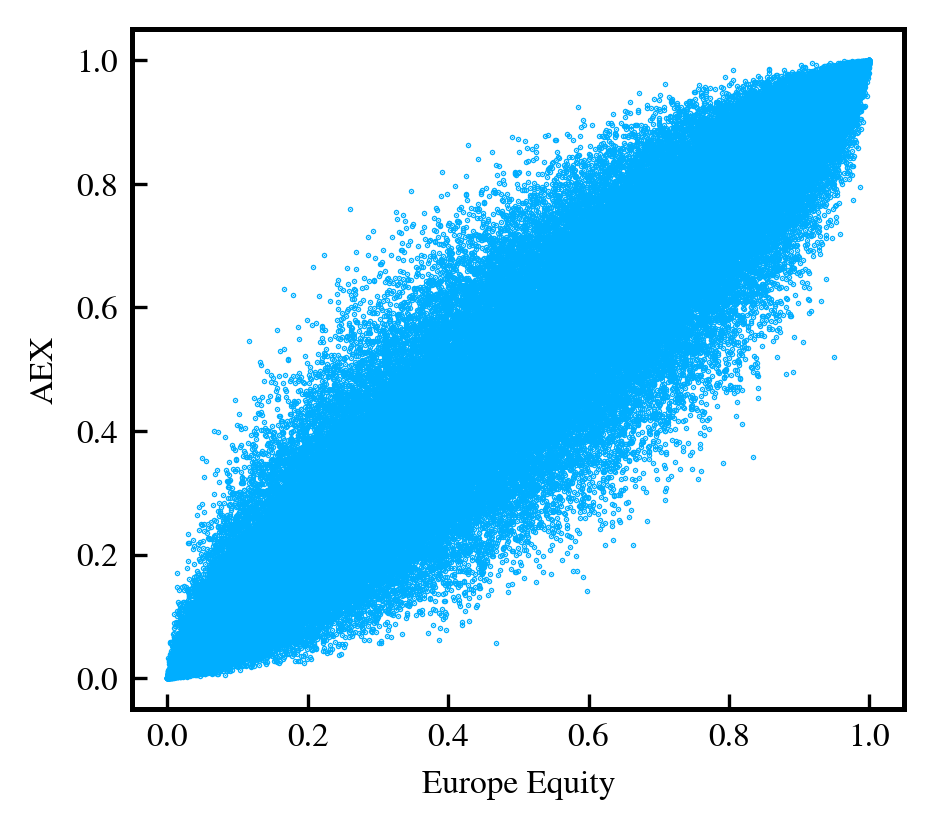

In [95]:
s=g_cop.random(100000)
s.plot.scatter(x='Europe Equity', y='AEX',s=0.1)

In [96]:
inv_nasdaq,_,_ = inverse_GMM_arbitraryCDF(ECDF(returns['Nasdaq']))
inv_eureq,_,_ = inverse_GMM_arbitraryCDF(ECDF(returns['Europe Equity']))

In [100]:
inv_aex,_,_ = inverse_GMM_arbitraryCDF(ECDF(returns['AEX']))

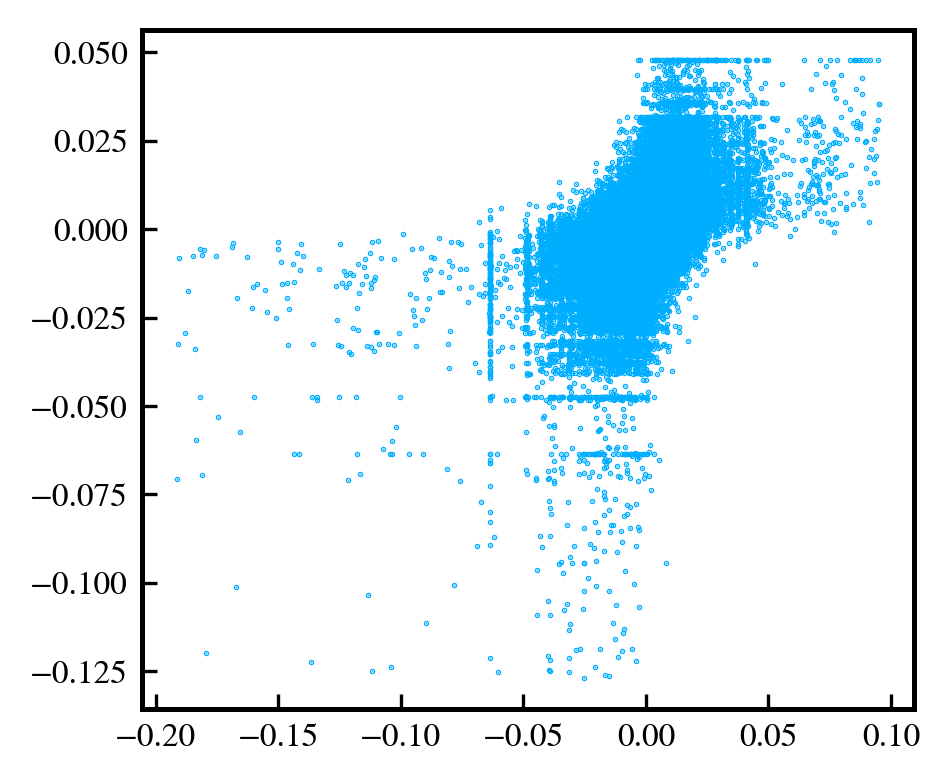

In [97]:
plt.scatter(inv_nasdaq(s['Nasdaq']),inv_eureq(s['Europe Equity']),s=0.1)
plt.show()

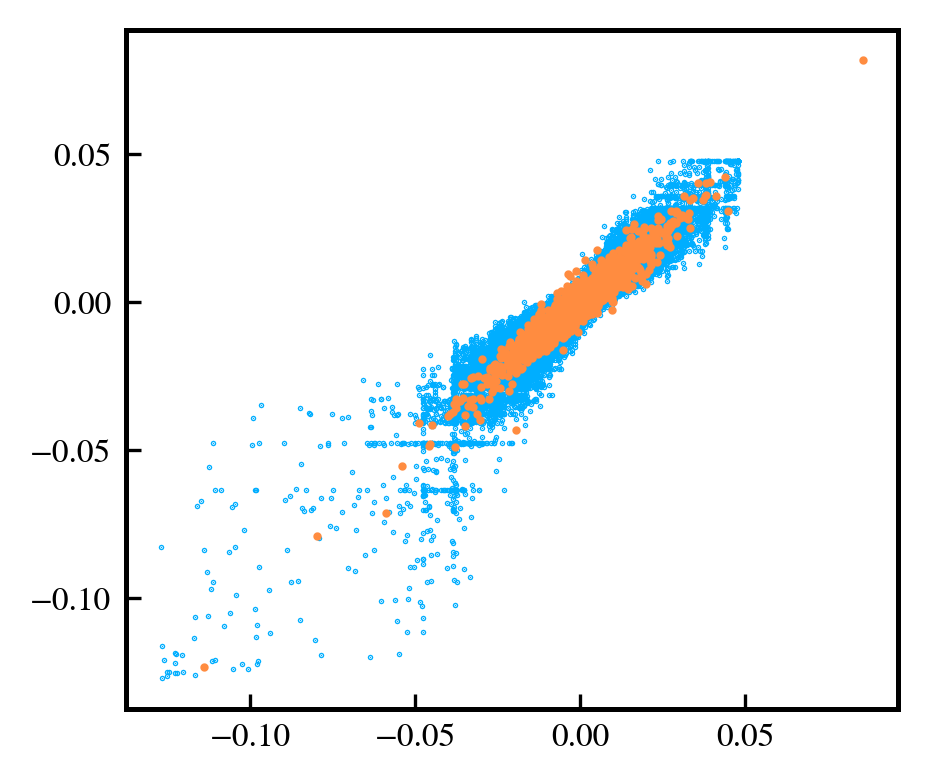

In [108]:
plt.scatter(inv_aex(s['AEX']),inv_eureq(s['Europe Equity']),s=0.1)
plt.scatter(returns['AEX'],returns['Europe Equity'],s=1)
plt.show()

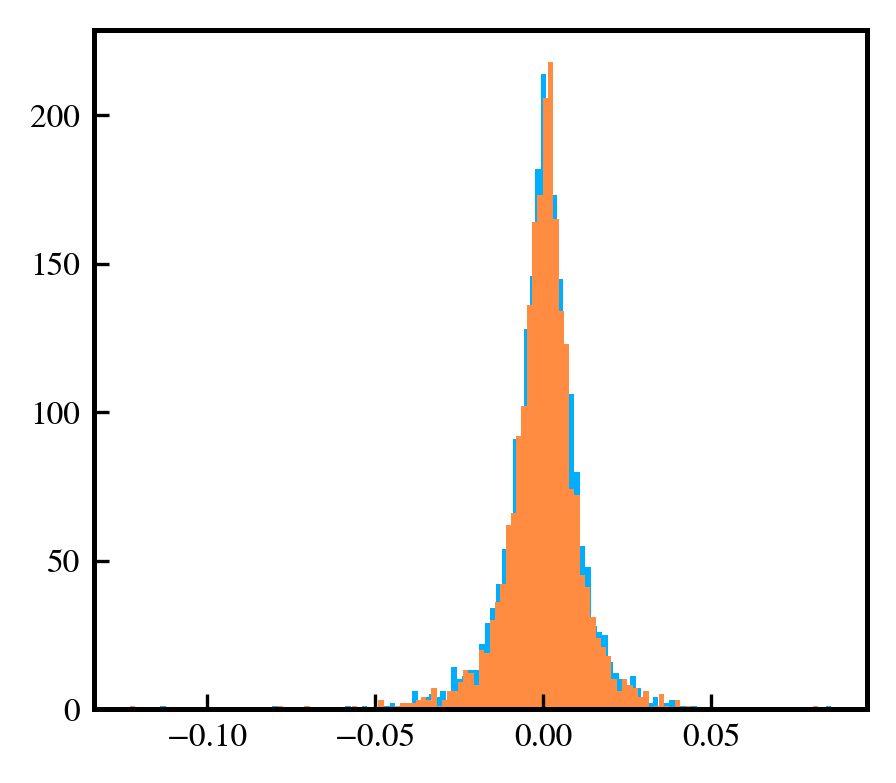

In [106]:
plt.hist(returns['AEX'])
plt.hist(returns['Europe Equity'])
plt.show()